In [1]:
import pandas as pd

In [2]:
data = pd.read_parquet('records/pred_alpha_cta.parquet')
data.head()

,date,Code,minTime,ret_15,pred_alpha
0,20240102,IM9999,101500,-0.000202,0.000417
1,20240102,IM9999,103000,0.000634,0.000015
2,20240102,IM9999,104500,-0.001118,-0.000010
3,20240102,IM9999,111500,-0.001019,0.000022
4,20240102,IM9999,133000,0.000535,0.000297


In [3]:
data['trade_time'] = pd.to_datetime(data['date'].astype(str) + data['minTime'].astype(str).str.zfill(6), format='%Y%m%d%H%M%S')
data = data.sort_values(by=['trade_time','Code'])
data.head()

,date,Code,minTime,ret_15,pred_alpha,trade_time
0,20240102,IM9999,101500,-0.000202,0.000417,2024-01-02 10:15:00
1,20240102,IM9999,103000,0.000634,0.000015,2024-01-02 10:30:00
2,20240102,IM9999,104500,-0.001118,-0.000010,2024-01-02 10:45:00
3,20240102,IM9999,111500,-0.001019,0.000022,2024-01-02 11:15:00
4,20240102,IM9999,133000,0.000535,0.000297,2024-01-02 13:30:00


In [4]:
from lumina.genetic.metrics.evaluate import FactorEvaluate

In [5]:
fe = FactorEvaluate(
        factor_data=data,
        factor_name='pred_alpha',
        ret_name='ret_15',
        roll_win=240,  # 因子放缩窗口，自定义
        fee= 0.00005,
        scale_method='roll_min_max')

In [6]:
fe.run()

{'total_ret': 0.20114464360248774,
 'avg_ret': 0.00010791621972664862,
 'max_dd': -0.026849757552138587,
 'calmar': 7.491488264349953,
 'sharpe': 1.1496681878286865,
 'turnover': 0.24944081308244717,
 'win_rate': 0.43098159509202455,
 'profit_ratio': 1.3040520008027248,
 'ic_mean': 0.06620235748376264,
 'ic_std': 0.09558712739266907,
 'ic_ir': 0.6925865363837678}

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

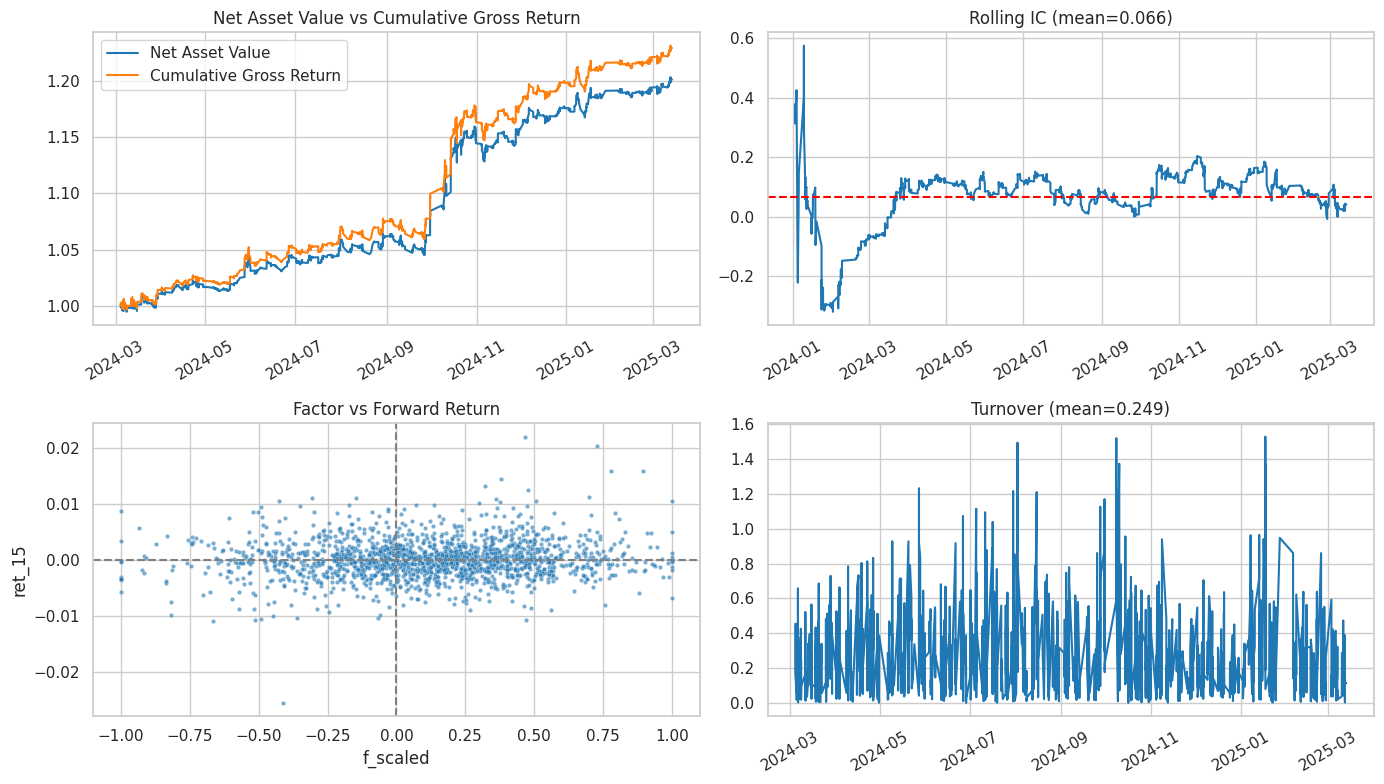

In [8]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. 净值 + 累计毛收益
axes[0, 0].plot(fe.factor_data['nav'], label='Net Asset Value')
cum_gross = (1 + fe.factor_data['gross_ret']).cumprod()
axes[0, 0].plot(cum_gross, label='Cumulative Gross Return')
axes[0, 0].set_title('Net Asset Value vs Cumulative Gross Return')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=30)


# 2. 滚动 IC
axes[0, 1].plot(fe.factor_data['ic'])
axes[0, 1].axhline(fe.factor_data['ic'].mean(), color='red', ls='--')
axes[0, 1].set_title(f'Rolling IC (mean={fe.factor_data["ic"].mean():.3f})')
axes[0, 1].tick_params(axis='x', rotation=30)

sns.scatterplot(x='f_scaled', y=fe.ret_name,
                        data=fe.factor_data, ax=axes[1, 0], s=10, alpha=0.6)
axes[1, 0].axhline(0, ls='--', c='grey')
axes[1, 0].axvline(0, ls='--', c='grey')
axes[1, 0].set_title('Factor vs Forward Return')


axes[1, 1].plot(fe.factor_data['turnover'])
axes[1, 1].set_title(f'Turnover (mean={fe.factor_data["turnover"].mean():.3f})')
axes[1, 1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()